# JupyterLab and Python: lab measurement workflow examples

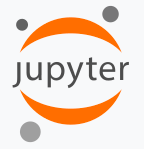

**Andrei Isichenko**$^1$, Nima Leclerc$^2$, Michael Choquer$^1$, Debapam Bose$^1$

$^1$ UC Santa Barbara, $^2$ UPenn


OFC hackathon [link](https://live.remo.co/e/ofc-hackathon-2021-2)

---

### Agenda

- what is Jupyter?

- how a Jupyter notebook is a "front-end" in lab instrument automation

- overview of instrument control code and organization


In [2]:
# Imports (can be abstracted away)
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from laserlab.servers.instruments.electronic.scopes.Keysight_DSOX_1204G_scope import Keysight_DSOX_1204G
from laserlab.servers.instruments.optical.passive_optical.osa.Agilent_86140B_osa import Agilent_86140B
from laserlab.servers.instruments.electronic.keithley.Keithley_2602A_SMU import Keithley_2602A
from laserlab.measurements.frequency_noise.OFD_FN_measure import OFD_FN_measure

from data_analysis.noise.freq_noise.ofd import *
from data_analysis.resonators.get_q_from_mzi import *
from data_analysis.core.box_integration import get_box_path

## Instrument initialization

- Keysight oscilloscope

- Agilent optical spectrum analyzer (OSA)

- Keithley source-measurement unit


In [3]:
k = Keithley_2602A("TCPIP::192.168.1.101::INSTR")
s = Keysight_DSOX_1204G("TCPIP::192.168.1.200::INSTR")
osa = Agilent_86140B(use_prologix=True, IP_prologix='192.168.1.212', CH_prologix=10)

KEYSIGHT TECHNOLOGIES,DSOX1204G,CN58467673,02.11.2020062221



## Example: Ring resonator FSR and Q measurements

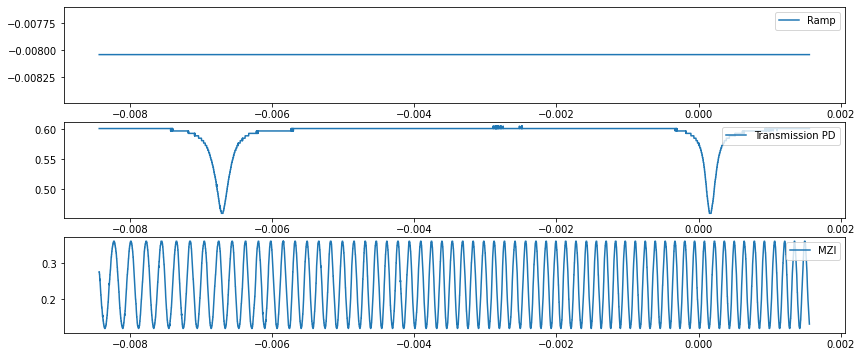

In [7]:
real_time_Q(scope=s)
# press the square in the toolbar above to stop this view

In [41]:
base_path = 'data/andrei'
path = get_box_path(base_path, filename='auto_q_test_1.csv')
q_meas = calib_mzi_measure(path, scope=s)
q_meas.acquire(trans_chan=1, mzi_chan=2, ramp_chan=3, mzi_fsr=5.87)

In [36]:
# generate a pandas dataframe
df = gen_df_from_data(path)
df.head() # view first few lines

,Unnamed: 0,mzi_pd,trans_pd,t,ramp
0,0,0.276196,0.600835,-0.008438,-0.00804
1,1,0.276196,0.600835,-0.008437,-0.00804
2,2,0.272176,0.600835,-0.008436,-0.00804
3,3,0.268156,0.600835,-0.008435,-0.00804
4,4,0.264136,0.600835,-0.008434,-0.00804


### Data analysis for this device

Immediately after acquiring, run the analysis

Note this requires you to know:

- resonance wavelength
- waveguide group index
- resonator length

Below, adjust the window size in range 11 to 101 and peak heigh 0.7 through 0.9, until solution is reached

1163
1399
[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1180
    # variables        = 3
    chi-square         = 0.02195385
    reduced chi-square = 1.8652e-05
    Akaike info crit   = -12846.6571
    Bayesian info crit = -12831.4373
[[Variables]]
    amplitude:  2.33981066 +/- 0.00477528 (0.20%) (init = 2.938776)
    center:     0.38282121 +/- 0.00648860 (1.69%) (init = 0.3441231)
    sigma:      3.20885656 +/- 0.00940434 (0.29%) (init = 3.467936)
    fwhm:       6.41771312 +/- 0.01880867 (0.29%) == '2.0000000*sigma'
    height:     0.23210290 +/- 4.8376e-04 (0.21%) == '0.3183099*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) =  0.703
Qload=  30137602.804849267
Extinction ratio=  1.2974564086600326

solution 1:
propagation loss 0.8163309190232021 dB/m
coupling coeff 0.0006142199187842746
coupling coeff [dB] -32.11676103

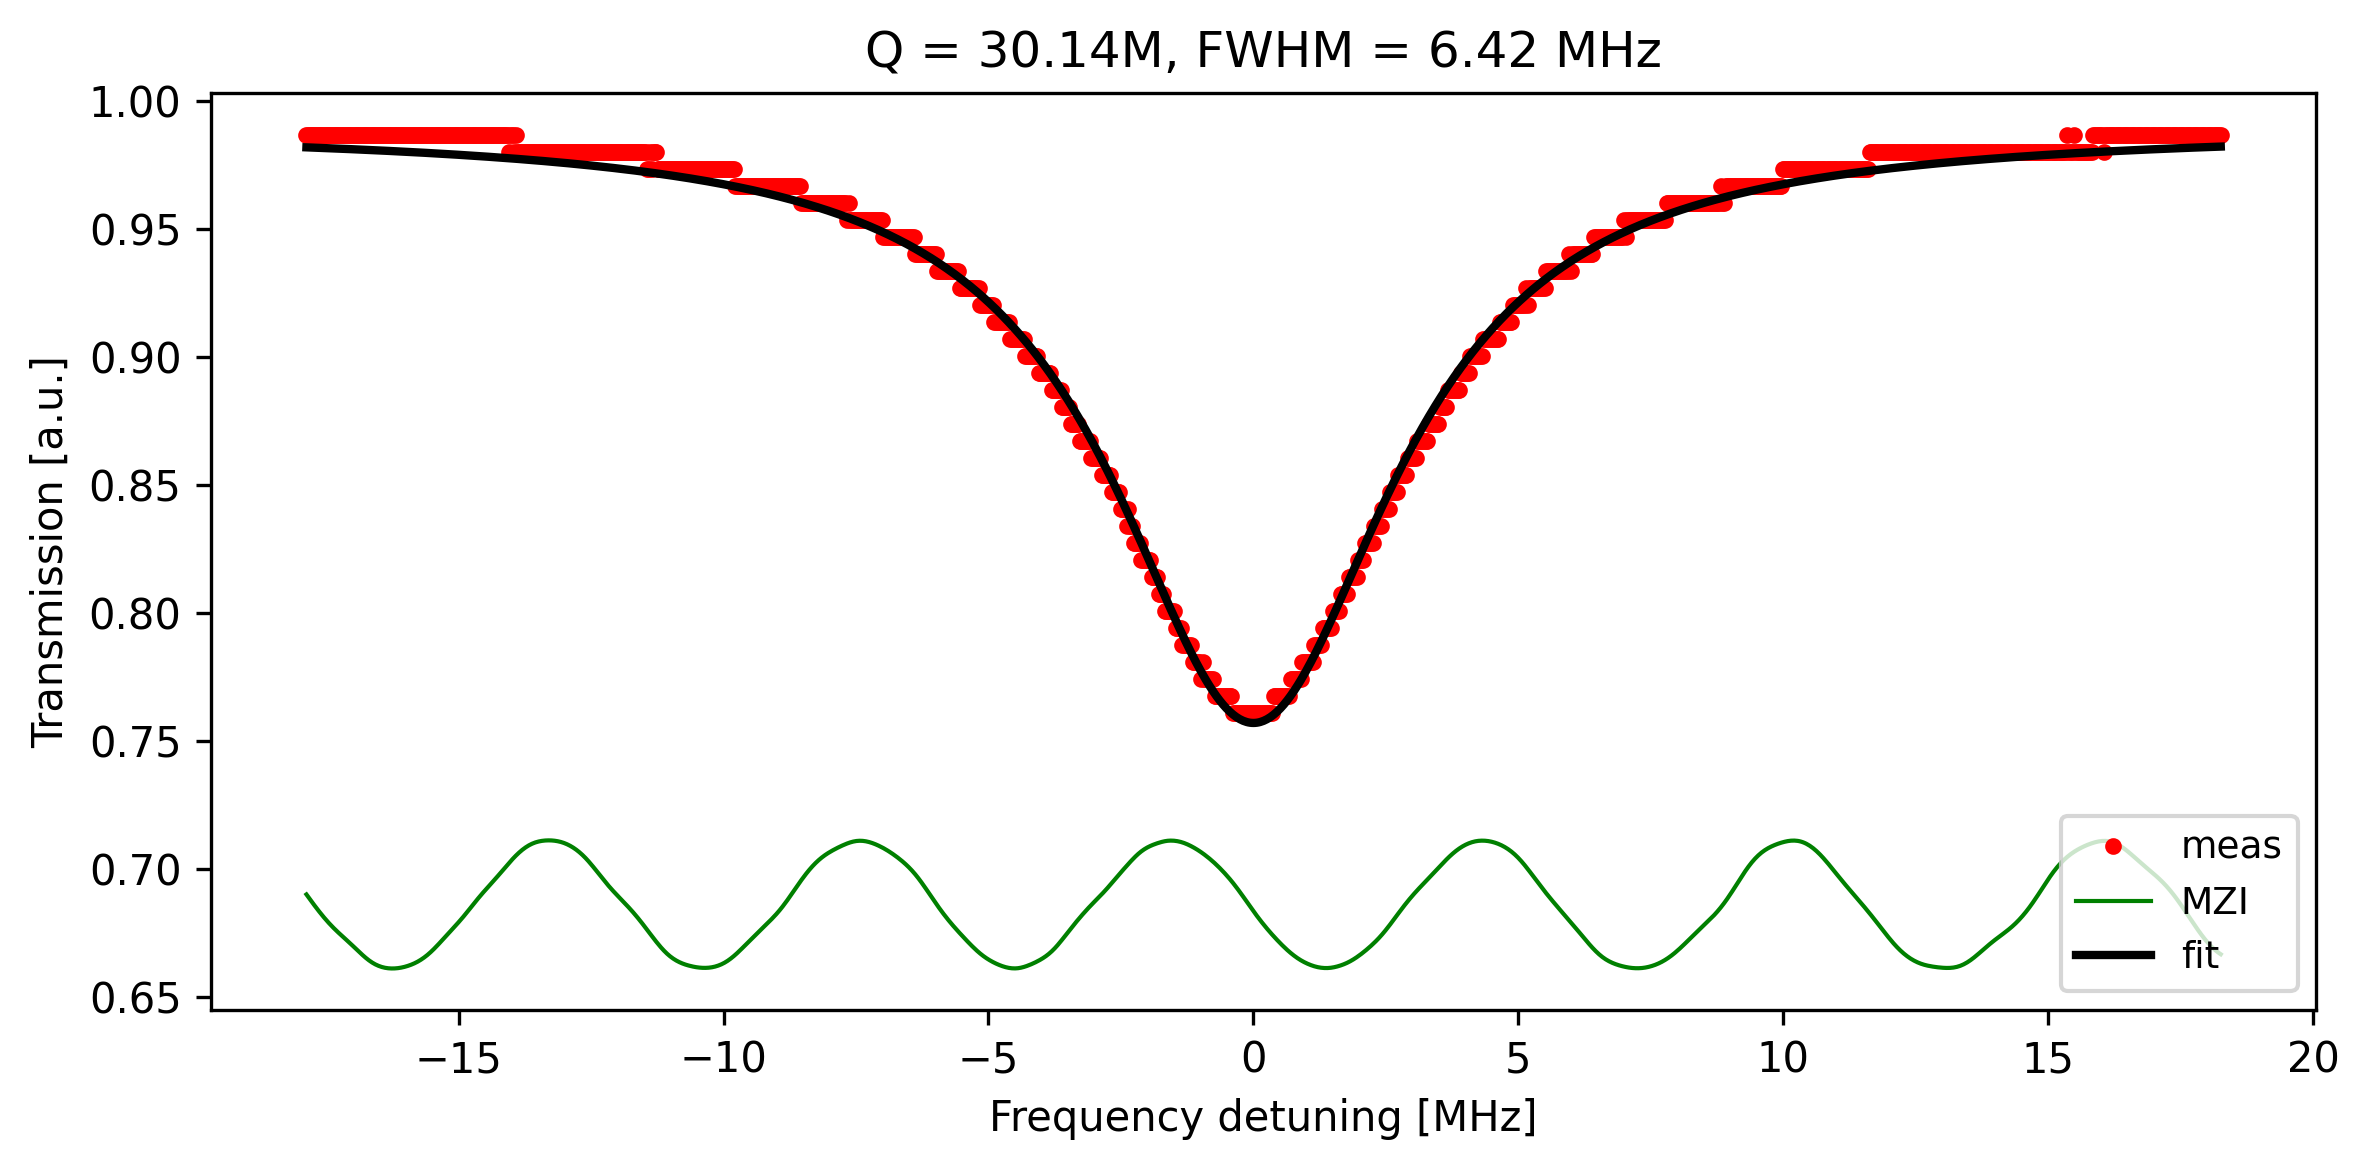

In [46]:
q_data = get_q_from_mzi(df, wl_res=1550e-9, fsr_mzi=5.87, wg_ng=1.4883, len_res=2*np.pi*8e-3,
                   window_size=21, peak_height=0.8, debug=False)

# plot it
plot_q_from_mzi(q_data, save_fig_path=False)

---
## Example: I-V sweeps



In [ ]:
k.set_output_mode(channel='b', mode='voltage')
k.set_current_limit(channel='b',current=10e-3)

In [ ]:
start = -8.5
stop = 1
steps = 100

k.output_state(channel='a', state='on')
voltages = np.linspace(start, stop, steps)
meas_i = []
meas_v = []
for v in voltages:
    k.set_voltage(channel='a',voltage=v)
    tup = k.measure_iv_grouped(channel='a')
    meas_i.append(tup[0])
    meas_v.append(tup[1])
k.output_state(channel='a', state='off')

# save
filename = 'test_iv.csv'
path = get_box_path('data/iv_sweeps', filename)
df = pd.DataFrame({'V': meas_v, 'I': meas_i})
df.to_csv(path)

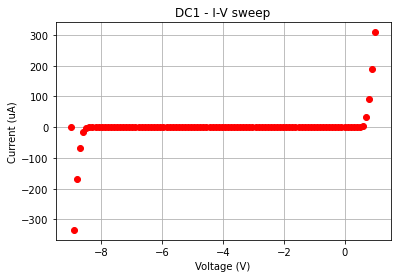

In [87]:
plt.plot(df['V'], df['I']*1e6, 'ro')
plt.grid('on')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.title('DC1 - I-V sweep')
plt.show()

---

## Example: Laser characterization

### Capture a laser's optical spectrum

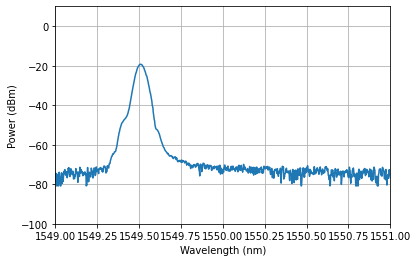

In [11]:
## OSA trace
osa.get_trace()

### Measure the laser's frequency noise

Complicated code to trigger and capture data on an oscilloscope. Abstracted-away classes allow for ease of use.

In [28]:
filename = 'optical_frequency_noise_measurement.h5'
base_path = 'data/freq_noise/ofd'
notes = 'simple notes about your experiment, including parameters'

path = get_box_path(base_path, filename)
ofd_meas = OFD_FN_measure(path, scope=s)

numPts = 2**15
sRate = [1e6, 20e6]

# run measurement
ofd_meas.run_OFD_measurement(mzi_fsr=18e6, rf_chan=1, mon_chan=2, sRate=sRate, ramp_freq=1, numPts=numPts, notes=notes)

Ensure that you can reach a full Vpp by ramping the MZI


Press enter to continue 


Vpp=4.33000 acquired. RF chan offset=-0.06500. Stop ramping the MZI


Press enter to continue 


Acquisition memory segments: 8
Number of segments in acquired data: 8
Num wf pts to be transferred when using wfDATA? query: 25625
Acquisition memory segments: 8
Number of segments in acquired data: 8
Num wf pts to be transferred when using wfDATA? query: 25000


In [8]:
filename='ofd_fn_with_1204G_morton_laser_EG_mzi18MHz_two_sRates.h5'
path = get_box_path('data/laser_fn/morton_laser_EG', filename)
%matplotlib widget
ofd_calc = OFDAnalysis(path, filename, plotting=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

---
## Experiment conclusions

Today in lab I did ______ and we realized the following

- laser settings
- noise issues

Export jupyter notebook as a PDF!

---

## How do we do this?

- Instrument control repository organization

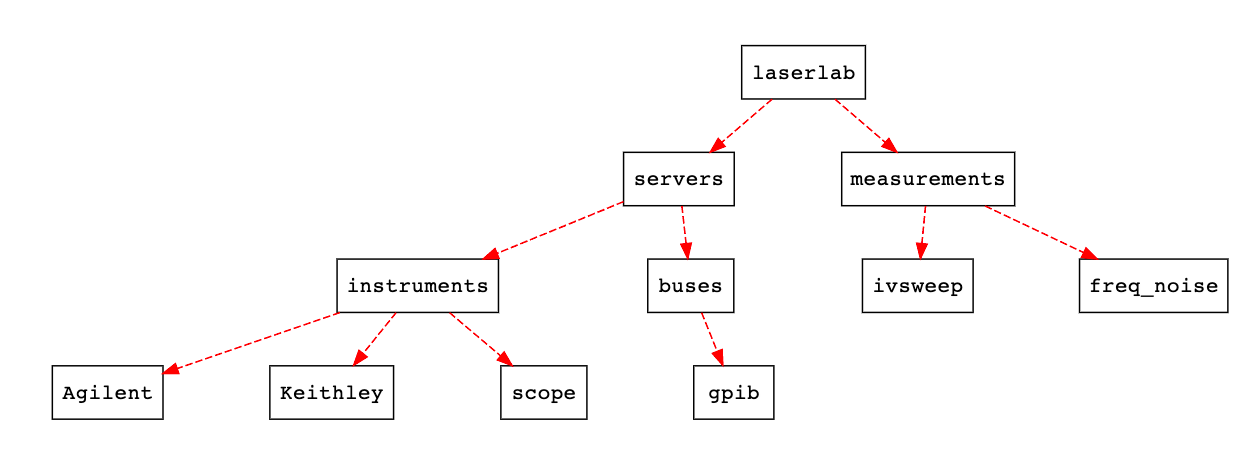

- Internal lab network (192.168.1.xxx)

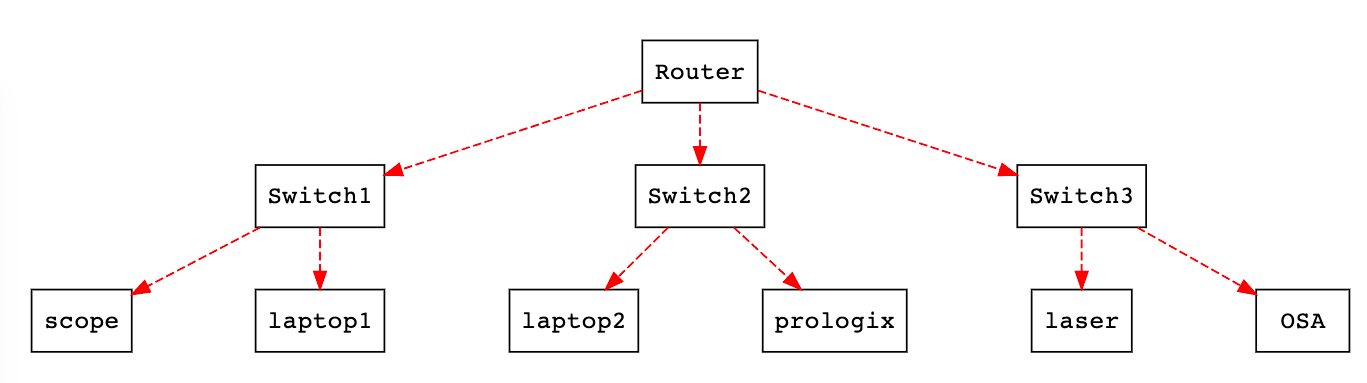

- `pyvisa` [library](https://pyvisa.readthedocs.io/en/latest/)

- [NI VISA server](https://www.ni.com/en-us/support/downloads/drivers/download.ni-visa.html#346210) 

---

## Moving forward

- JupyterHub, all users in lab log into a website:
    
ocpi.ece.ucsb.edu/labhub

then log in with their credentials:

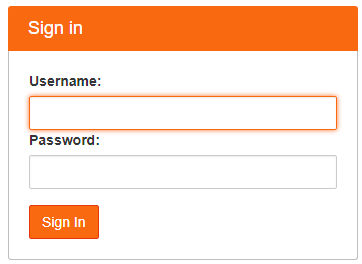

This opens up a repository of notebooks to run experiments, from their own computers, using the most up-to-date code.

---

## Jupyter and Python tips and tricks

- [matplotlib widgets for jupyter](https://github.com/matplotlib/ipympl)

- save a Python dictionary (just like matlab struct) to an h5 file using [deepdish](https://github.com/uchicago-cs/deepdish)

- useful lab automation repository from Princeton: [lightlab](https://github.com/lightwave-lab/lightlab)

---
## Acknowledgements

- Joaquin Matres for Python inspiration

- Nicholas Fontaine for organizing